In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import os
import pandas as pd
import json
from dotenv import load_dotenv
import boto3
from botocore.config import Config
from openai import OpenAI

load_dotenv("codes.env")

# AWS credentials
aws_access_key = os.environ.get("AWS_ACCESS_KEY_ID")
aws_secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
aws_region = os.environ.get("AWS_REGION")

# OpenAI credentials
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# AWS Bedrock model configuration
MODEL_ID_LLAMA = "arn:aws:bedrock:us-east-1:874280117166:inference-profile/us.meta.llama3-3-70b-instruct-v1:0"

# Prevent Bedrock timeout
config = Config(read_timeout=1000)

client = boto3.client(
    "bedrock-runtime",
    region_name=aws_region,
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    config=config
)

# Load file-topic mapping
mapping_file_path = 'final_file_topic_mapping.csv'
data_folder_path = 'Cleaned_Data'
file_topic_mapping = pd.read_csv(mapping_file_path)
unique_topics = file_topic_mapping['folder_name'].unique().tolist()
unique_topics_str = ', '.join(unique_topics)

# Read a .txt file's content
def read_txt_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# Map outputs to categories
def map_to_category(predicted_output):
    predicted_output = predicted_output.lower().strip()
    for topic in unique_topics:
        if topic.lower() in predicted_output:
            return topic
    return "unknown"

# Function to search for the correct file path recursively
def find_file_recursive(base_folder, expected_topic, file_name):
    """
    Recursively searches for the given file inside the base folder.
    Returns the correct file path if found, otherwise returns None.
    """
    for root, _, files in os.walk(base_folder):
        if file_name in files:
            return os.path.join(root, file_name)
    return None  # Return None if file not found

# OpenAI's GPT-4o
def evaluate_topic_with_gpt4o(file_content):
    try:
        response = openai_client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are an expert document classifier."},
                {"role": "user", "content": f"Classify the following text into one of these topics: {unique_topics_str}. \n{file_content}"},
            ],
            model="gpt-4o",
            temperature=0,
        )
        predicted_topic = response.choices[0].message.content
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return "unknown"

# AWS Bedrock (Meta's Llama 3.3)
def evaluate_topic_with_llama(file_content):
    try:
        prompt = f"Classify the following text into only one of these topics: {unique_topics_str}. \n{file_content}"
        formatted_prompt = f"""
            <|begin_of_text|>
            <|start_header_id|>user<|end_header_id|>
            {prompt}
            <|eot_id|>
            <|start_header_id|>assistant<|end_header_id|>
            """
        response = client.invoke_model(
            modelId=MODEL_ID_LLAMA,
            body=json.dumps({
                "prompt": formatted_prompt,
                "max_gen_len": 512,
                "temperature": 0,
            }),
            contentType="application/json"
        )
        response_body = json.loads(response['body'].read())
        predicted_topic = response_body.get("generation", "").strip()
        if not predicted_topic:
            print("Empty response from AWS Bedrock Llama, defaulting to unknown.")
        return map_to_category(predicted_topic)
    except Exception as e:
        print(f"Error calling AWS Bedrock API: {e}")
        return "unknown"

# Evaluate files function
def evaluate_files():
    results = []
    base_folder = 'Cleaned_Data_v2'

    for _, row in file_topic_mapping.iterrows():
        relative_path = row['file_name']
        expected_topic = row['folder_name'].strip()
        
        # Dynamically find the file location
        file_path = find_file_recursive(base_folder, expected_topic, relative_path)

        if not file_path:
            print(f"Error: File not found - {relative_path}")
            continue

        content = read_txt_file(file_path)
        if not content:
            continue

        predicted_topic_gpt4o = evaluate_topic_with_gpt4o(content)
        predicted_topic_llama = evaluate_topic_with_llama(content)

        print(f"File: {relative_path}")
        print(f"Expected Topic: {expected_topic}")
        print(f"GPT-4o Predicted Topic: {predicted_topic_gpt4o}")
        print(f"Llama 3.3 Predicted Topic: {predicted_topic_llama}\n")

        results.append({
            'file_path': file_path,
            'expected_topic': expected_topic,
            'predicted_topic_gpt4o': predicted_topic_gpt4o,
            'predicted_topic_llama': predicted_topic_llama
        })

    return pd.DataFrame(results)

# Evaluate all files
results_df = evaluate_files()

# Save results
output_csv_path = 'topic_evaluation_results.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"Evaluation results saved to {output_csv_path}")

File: 243 - Winning Strategies for B2B SaaS Companies - BCG - www.bcg.com.txt
Expected Topic: Marketing and Public Communication
GPT-4o Predicted Topic: Technology
Llama 3.3 Predicted Topic: Technology

File: 244 - Global Search Engine Decision on The Future of Third-Party Cookies - BCG - www.bcg.com.txt
Expected Topic: Marketing and Public Communication
GPT-4o Predicted Topic: Marketing and Public Communication
Llama 3.3 Predicted Topic: Marketing and Public Communication

File: personalization-in-action.txt
Expected Topic: Marketing and Public Communication
GPT-4o Predicted Topic: Marketing and Public Communication
Llama 3.3 Predicted Topic: Investment and Market Research

File: 242 - Loyalty Programs and Customer Expectations Are Growing - BCG - www.bcg.com.txt
Expected Topic: Marketing and Public Communication
GPT-4o Predicted Topic: Marketing and Public Communication
Llama 3.3 Predicted Topic: Marketing and Public Communication

File: 245 - GenAI’s Influence on Future Creativity i

GPT-4o Classification Report:
                                        precision    recall  f1-score   support

                        Administrative       0.00      0.00      0.00         4
                        Annual Reports       0.50      0.86      0.63        14
                 Anti Money Laundering       0.94      0.56      0.70        27
                         Audit Reports       0.83      0.71      0.77        14
                     Client Agreements       0.64      0.64      0.64        11
                      Consumer Finance       0.00      0.00      0.00        10
                           Derivatives       0.60      0.50      0.55         6
                            Employment       0.75      0.86      0.80         7
                 Financial Regulations       0.25      0.06      0.10        17
                  Financial Statements       0.92      0.74      0.82       104
        Investment and Market Research       0.67      0.86      0.75         7
         

/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


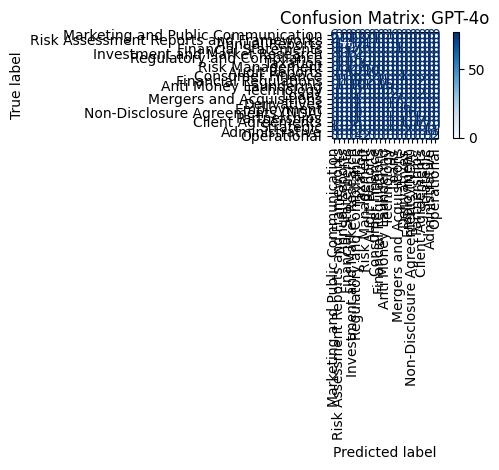

AWS Bedrock Llama Classification Report:
                                        precision    recall  f1-score   support

                        Administrative       1.00      0.25      0.40         4
                        Annual Reports       0.40      1.00      0.57        14
                 Anti Money Laundering       0.92      0.81      0.86        27
                         Audit Reports       0.77      0.71      0.74        14
                     Client Agreements       0.67      0.73      0.70        11
                      Consumer Finance       0.00      0.00      0.00        10
                           Derivatives       0.80      0.67      0.73         6
                            Employment       0.78      1.00      0.88         7
                 Financial Regulations       0.00      0.00      0.00        17
                  Financial Statements       0.87      0.62      0.73       104
        Investment and Market Research       0.44      1.00      0.61         

/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jaron/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


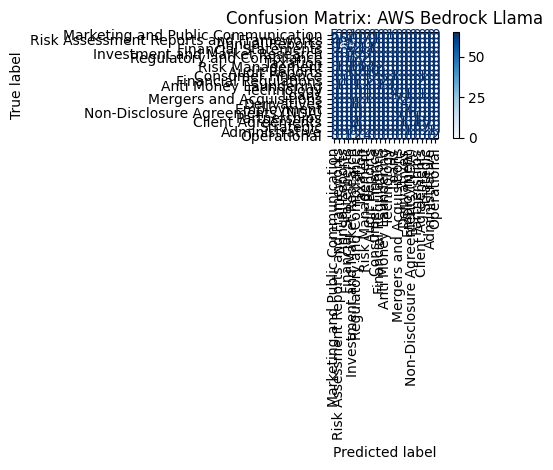

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

results_df = pd.read_csv("topic_evaluation_results.csv")

# Confusion matrix plotting
def plot_confusion_matrix(expected, predicted, model_name):
    cm = confusion_matrix(expected, predicted, labels=unique_topics)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_topics)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.tight_layout()
    plt.show()

# Model performance evaluation
def evaluate_model_performance():
    expected_topics = results_df['expected_topic']

    models = {
        "GPT-4o": results_df['predicted_topic_gpt4o'],
        "AWS Bedrock Llama": results_df['predicted_topic_llama'],
    }

    for model_name, predicted_topics in models.items():
        print(f"{model_name} Classification Report:")
        print(classification_report(expected_topics, predicted_topics))
        plot_confusion_matrix(expected_topics, predicted_topics, model_name)

# Run performance evaluation
evaluate_model_performance()

<Figure size 1200x800 with 0 Axes>

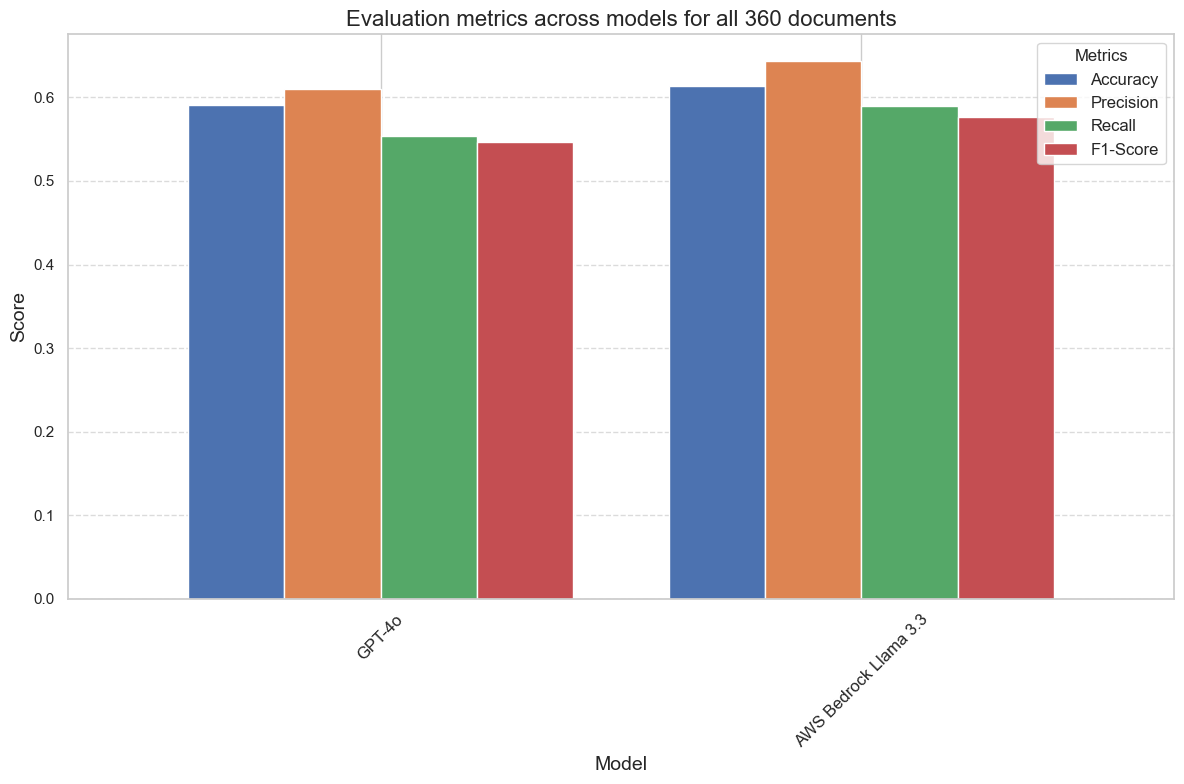

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

results_df = pd.read_csv("topic_evaluation_results.csv")

# Model names for evaluation
model_columns = ["predicted_topic_gpt4o", "predicted_topic_llama"]
model_names = ["GPT-4o", "AWS Bedrock Llama 3.3"]

metrics_data = []

for model_name, model_column in zip(model_names, model_columns):
    report = classification_report(
        results_df["expected_topic"], 
        results_df[model_column], 
        output_dict=True, 
        zero_division=0
    )
    
    metrics_data.append({
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Precision": report["macro avg"]["precision"],
        "Recall": report["macro avg"]["recall"],
        "F1-Score": report["macro avg"]["f1-score"]
    })

metrics_df = pd.DataFrame(metrics_data)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 8), width=0.8)
plt.title("Evaluation metrics across models for all 360 documents", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Metrics", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()